In [1]:
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Permute
from keras.layers import ConvLSTM2D, Conv2D, MaxPooling2D
from keras.layers import MaxPooling1D, Conv1D
from keras.layers import GRU, LSTM, BatchNormalization
from keras.layers import TimeDistributed
from keras.layers import Flatten, Reshape, Dropout
from keras.utils import to_categorical
from keras.layers import Activation
from keras import regularizers

from sklearn.metrics import confusion_matrix

from UtilNNDL import create_window_data
from UtilNNDL import plot_hist
from UtilNNDL import prepare_data
from UtilNNDL import plot_confusion_matrix
from UtilNNDL import bandpass_cnt
from UtilNNDL import exponential_running_standardize

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

Using TensorFlow backend.


In [20]:
#Prepare the data by taking out nans and dividing into test and train
file_path = 'datasets/'
file_path = '/home/carla/Downloads/project_datasets/project_datasets/'
train_data, test_data, train_labels, test_labels = prepare_data(file_path, 
                                                                num_test_samples = 50, 
                                                                verbose= False, 
                                                                return_all=True,
                                                                num_files =9)

In [21]:
print train_data.shape
print train_labels.shape

# Test on the first 50 samples of subject 1
#test_data = test_data[0:50]
#test_labels = test_labels[0:50]

print test_data.shape
print test_labels.shape


(2108, 22, 1000)
(2108, 4)
(450, 22, 1000)
(450, 4)


In [22]:
#assist numerical stability
train_data = train_data*(1e6)
test_data = test_data*(1e6)
train_data = train_data.swapaxes(1,2)
test_data = test_data.swapaxes(1,2)
print train_data.shape
print test_data.shape
for i,a in enumerate(train_data):
    train_data[i] = bandpass_cnt(a, 4, 38, 250, filt_order=3)
for i,a in enumerate(test_data):
    test_data[i] = bandpass_cnt(a, 4, 38, 250, filt_order=3)    
print train_data.shape
print test_data.shape

(2108, 1000, 22)
(450, 1000, 22)
(2108, 1000, 22)
(450, 1000, 22)


In [5]:
#Standardize the data
for i,a in enumerate(train_data):
    train_data[i] = exponential_running_standardize(a, factor_new=0.001, init_block_size=1000, eps=1e-4)
for i,a in enumerate(test_data):
    test_data[i] = exponential_running_standardize(a, factor_new=0.001, init_block_size=1000, eps=1e-4)
train_data = train_data.swapaxes(1,2)
test_data = test_data.swapaxes(1,2) 
print train_data.shape
print test_data.shape

(2108, 22, 1000)
(50, 22, 1000)


In [23]:
#Augment the data into a bigger set by windowing
train_data_sliced, train_labels_sliced = create_window_data(train_data, train_labels, windows=10)
test_data_sliced, test_labels_sliced = create_window_data(test_data, test_labels, windows=10)
print train_data_sliced.shape
print train_labels_sliced.shape
print test_data_sliced.shape
print test_labels_sliced.shape 

MemoryError: 

In [7]:
test_data_sliced = test_data_sliced[:500,:]
test_labels_sliced = test_labels_sliced[:500,:]
print test_data_sliced.shape
print test_labels_sliced.shape 

(500, 22, 512)
(500, 4)


In [8]:
traindata2d = train_data_sliced.reshape(train_data_sliced.shape[0], train_data_sliced.shape[2], train_data_sliced.shape[1], 1)
testdata2d = test_data_sliced.reshape(test_data_sliced.shape[0], test_data_sliced.shape[2], test_data_sliced.shape[1], 1)
print traindata2d.shape
print testdata2d.shape

(21080, 512, 22, 1)
(500, 512, 22, 1)


# TESTING


Trying out:
    * X batchnorm before nonlinearity
    * X regularization
    * dropout 0.5 applied to inputs to conv layers after the first
    * “new tied loss function” for further regularization

In [10]:
num_filters = 20 #15 performs similar
model = Sequential()
model.add(Conv2D(num_filters, kernel_size=(num_filters,1), data_format='channels_last', input_shape=(traindata2d.shape[1], traindata2d.shape[2], traindata2d.shape[3]), kernel_initializer='glorot_normal', bias_initializer='glorot_normal'))  
model.add(Conv2D(num_filters, kernel_size=(15,num_filters), activation='relu', kernel_initializer='glorot_normal', bias_initializer='glorot_normal') ) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))
model.add(Dropout(0.5))

model.add(Conv2D(num_filters*2, kernel_size=(10,num_filters), activation='relu', kernel_initializer='glorot_normal', bias_initializer='glorot_normal')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))
model.add(Dropout(0.5))

model.add(Conv2D(num_filters*4, kernel_size=(10,num_filters*2), activation='relu', kernel_initializer='glorot_normal', bias_initializer='glorot_normal')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))
model.add(Dropout(0.5))

model.add(Conv2D(num_filters*8, kernel_size=(10,num_filters*4), activation='relu', kernel_initializer='glorot_normal', bias_initializer='glorot_normal')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Reshape((num_filters*8,1)))
#model.add(LSTM(32, return_sequences=True))

model.add(Flatten())
model.add(Dense(4, activation='softmax', kernel_initializer='glorot_normal', bias_initializer='glorot_normal'))
model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])
model.summary()
hist = model.fit(traindata2d,train_labels_sliced,epochs=45,validation_split=0.25,batch_size=16)
#model.test_on_batch(test_data, test_labels)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 493, 22, 20)       420       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 479, 3, 20)        120020    
_________________________________________________________________
batch_normalization_5 (Batch (None, 479, 3, 20)        80        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 159, 3, 20)        0         
_________________________________________________________________
permute_4 (Permute)          (None, 159, 20, 3)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 159, 20, 3)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 150, 1, 40)        24040     
__________

15810/15810 [==============================] - 26s 2ms/step - loss: 0.9502 - acc: 0.5972 - val_loss: 1.4561 - val_acc: 0.4871
Epoch 37/45
15810/15810 [==============================] - 26s 2ms/step - loss: 0.9424 - acc: 0.6006 - val_loss: 1.9099 - val_acc: 0.4288
Epoch 38/45
15810/15810 [==============================] - 26s 2ms/step - loss: 0.9379 - acc: 0.6003 - val_loss: 1.4692 - val_acc: 0.4820
Epoch 39/45
15810/15810 [==============================] - 27s 2ms/step - loss: 0.9436 - acc: 0.6013 - val_loss: 1.5508 - val_acc: 0.4433
Epoch 40/45
15810/15810 [==============================] - 26s 2ms/step - loss: 0.9284 - acc: 0.6104 - val_loss: 1.6037 - val_acc: 0.4664
Epoch 41/45
15810/15810 [==============================] - 26s 2ms/step - loss: 0.9333 - acc: 0.6037 - val_loss: 1.4851 - val_acc: 0.4848
Epoch 42/45
15810/15810 [==============================] - 26s 2ms/step - loss: 0.9287 - acc: 0.6073 - val_loss: 1.5452 - val_acc: 0.4702
Epoch 43/45
15810/15810 [=====================

(500, 512, 22, 1)
500/500 [==============================] - 0s 393us/step
Test Score: [0.85432510757446289, 0.61599999999999999]


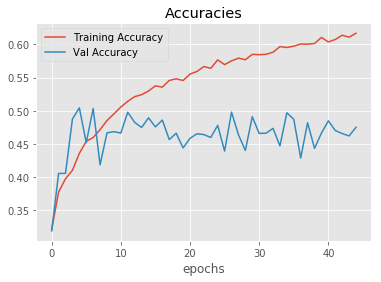

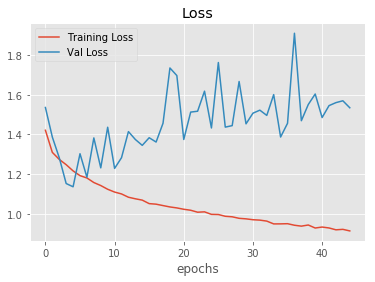

[130 120 130 120]
Confusion matrix, without normalization
[[84 42  3  1]
 [31 89  0  0]
 [19 22 75 14]
 [ 9  8 43 60]]


array([ 0.85432511,  0.616     ])

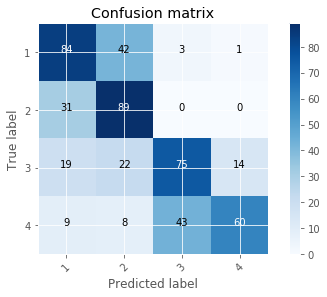

In [13]:
#First test on all subjects
print testdata2d.shape
test_score = model.evaluate(testdata2d, test_labels_sliced, batch_size=16)
print "Test Score: {}".format(test_score)
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Loss')

test_predict = model.predict(testdata2d, batch_size=16)
cm = confusion_matrix(np.argmax(test_labels_sliced,axis=1),np.argmax(test_predict,axis=1))
unique, count = np.unique(np.argmax(test_labels_sliced,axis=1),return_counts=True)
print count 
plt.figure(0)
plot_confusion_matrix(cm, classes=["1","2","3","4"])

#np.save('Best Models/Variables/DeepConvNet_hist_allto1.npy', hist.history)
#np.save('Best Models/Variables/DeepConvNet_conf_allto1.npy', cm)
#np.save('Best Models/Variables/DeepConvNet_testacc_allto1.npy', test_score)

#np.load('Best Models/Variables/DeepConvNet_testacc_allto1.npy')

In [17]:
# Modify test data to run model on another subject
_, test_data_orig, _, test_labels_orig = prepare_data(file_path, 
                                            num_test_samples=50, 
                                            verbose=False, 
                                            return_all=True,
                                            num_files=9)

In [29]:
print test_data_orig.shape
test_data = test_data_orig*(1e6)
test_data = test_data_orig.swapaxes(1,2)
for i,a in enumerate(test_data):
    test_data[i] = bandpass_cnt(a, 4, 38, 250, filt_order=3)    
    #print test_data.shape

#standardize
for i,a in enumerate(test_data):
    test_data[i] = exponential_running_standardize(a, factor_new=0.001, init_block_size=1000, eps=1e-4)

test_data = test_data.swapaxes(1,2) 
test_data_sliced, test_labels_sliced = create_window_data(test_data, test_labels, windows=10)

test_data_sliced = test_data_sliced[:500,:]
test_labels_sliced = test_labels_sliced[:500,:]
#print test_data_sliced.shape
#print test_labels_sliced.shape 

testdata2d = test_data_sliced.reshape(test_data_sliced.shape[0], test_data_sliced.shape[2], test_data_sliced.shape[1], 1)
#print testdata2d.shape
    
print testdata2d.shape
    

(450, 22, 1000)
(500, 512, 22, 1)


500/500 [==============================] - 0s 400us/step
Test Score: [0.80167359781265257, 0.63600000000000001]


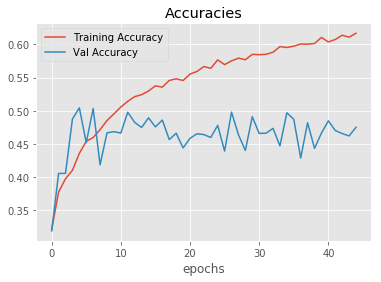

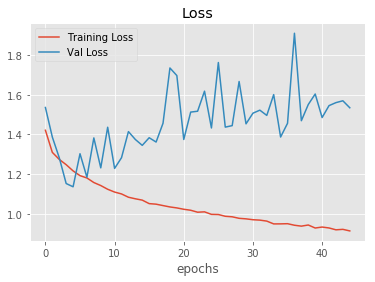

[130 120 130 120]
Confusion matrix, without normalization
[[87 21  8 14]
 [25 82  8  5]
 [ 6  7 70 47]
 [ 5  4 32 79]]


array([ 0.8016736,  0.636    ])

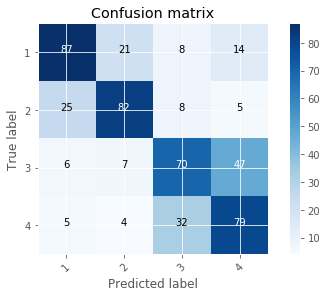

In [30]:
test_score = model.evaluate(testdata2d, test_labels_sliced, batch_size=16)
print "Test Score: {}".format(test_score)
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Loss')

test_predict = model.predict(testdata2d, batch_size=16)
cm = confusion_matrix(np.argmax(test_labels_sliced,axis=1),np.argmax(test_predict,axis=1))
unique, count = np.unique(np.argmax(test_labels_sliced,axis=1),return_counts=True)
print count 
plt.figure(0)
plot_confusion_matrix(cm, classes=["1","2","3","4"])

np.save('Best Models/Variables/DeepConvNet_hist_allto1.npy', hist.history)
np.save('Best Models/Variables/DeepConvNet_conf_allto1.npy', cm)
np.save('Best Models/Variables/DeepConvNet_testacc_allto1.npy', test_score)

np.load('Best Models/Variables/DeepConvNet_testacc_allto1.npy')

In [14]:
# Modify test data to run model on other subjects, separately
_, test_data_orig, _, test_labels_orig = prepare_data(file_path, 
                                            num_test_samples=50, 
                                            verbose=False, 
                                            return_all=False,
                                            num_files=9)


In [15]:
test_data_all = []
test_labels_all = []
for n in range(1,10):
    test_data = test_data_orig['A0{}T'.format(n)]
    test_labels = test_labels_orig['A0{}T'.format(n)]
    #print test_data.shape
    #print test_labels.shape

    #assist numerical stability
    test_data = test_data*(1e6)
    test_data = test_data.swapaxes(1,2)
    for i,a in enumerate(test_data):
        test_data[i] = bandpass_cnt(a, 4, 38, 250, filt_order=3)    
    #print test_data.shape

    #standardize
    for i,a in enumerate(test_data):
        test_data[i] = exponential_running_standardize(a, factor_new=0.001, init_block_size=1000, eps=1e-4)

    test_data = test_data.swapaxes(1,2) 
    test_data_sliced, test_labels_sliced = create_window_data(test_data, test_labels, windows=10)

    test_data_sliced = test_data_sliced[:500,:]
    test_labels_sliced = test_labels_sliced[:500,:]
    #print test_data_sliced.shape
    #print test_labels_sliced.shape 

    testdata2d = test_data_sliced.reshape(test_data_sliced.shape[0], test_data_sliced.shape[2], test_data_sliced.shape[1], 1)
    #print testdata2d.shape
    
    test_data_all.append(testdata2d)
    test_labels_all.append(test_labels_sliced)
    
print(len(test_data_all))
print(len(test_labels_all))
    

9
9


In [16]:
for n in range(0,9):
    testdata2d = test_data_all[n]
    test_labels_sliced = test_labels_all[n]
    test_score = model.evaluate(testdata2d, test_labels_sliced, batch_size=16)
    print "Test Score: {}".format(test_score)
    #plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
    #plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Loss')

    #test_predict = model.predict(testdata2d, batch_size=16)
    #cm = confusion_matrix(np.argmax(test_labels_sliced,axis=1),np.argmax(test_predict,axis=1))
    #unique, count = np.unique(np.argmax(test_labels_sliced,axis=1),return_counts=True)
    #print count 
    #plt.figure(0)
    #plot_confusion_matrix(cm, classes=["1","2","3","4"])

500/500 [==============================] - 0s 402us/step
Test Score: [0.85432510757446289, 0.61599999999999999]
500/500 [==============================] - 0s 395us/step
Test Score: [1.427659839630127, 0.37]
500/500 [==============================] - 0s 393us/step
Test Score: [1.0576762609481811, 0.63200000000000001]
500/500 [==============================] - 0s 399us/step
Test Score: [1.3834402589797974, 0.376]
500/500 [==============================] - 0s 435us/step
Test Score: [1.5514984436035155, 0.28799999999999998]
500/500 [==============================] - 0s 479us/step
Test Score: [1.4794030466079713, 0.372]
500/500 [==============================] - 0s 445us/step
Test Score: [1.1396646614074708, 0.50600000000000001]
500/500 [==============================] - 0s 520us/step
Test Score: [1.8904519882202149, 0.42199999999999999]
500/500 [==============================] - 0s 449us/step
Test Score: [2.1849600257873534, 0.28599999999999998]


In [43]:
print traindata2d.shape

(21080, 512, 22, 1)
